In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import random
import os
import torch
import torchvision
import torchvision.transforms as transforms
import time

from torchvision import models
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xmltodict
import xmltodict

**Load Dataset** 

Images are png files, annotations are xml files. 

In [ ]:
proj_path = "/content/drive/MyDrive/COM_S_573_Project"
img_path = proj_path + "/data/images/"
xml_path = proj_path + "/data/annotations/"
imgs = sorted([f for f in os.listdir(img_path)])
xmls = sorted([f for f in os.listdir(xml_path)])

Final all the labels from xml files: "without_mask", "with_mask", "mask_weared_incorrect"

In [ ]:
listing = []
for f in xmls:
  fd = open(xml_path + f)
  doc = xmltodict.parse(fd.read())
  obj = doc["annotation"]["object"]
  if type(obj) == list:
    for i in range(len(obj)):
      listing.append(obj[i]["name"])
  else:
    listing.append(obj["name"])

mask_labels = list(Counter(listing).keys())
mask_values = list(Counter(listing).values())

print("Labels:", mask_labels)
print("Number of each labels:", mask_values)


Labels: ['without_mask', 'with_mask', 'mask_weared_incorrect']
Number of each labels: [717, 3232, 123]


Create final dataset and process to torch tensors.

labels index: {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 2}

In [ ]:
class FaceMaskDataset(Dataset):
  def __init__(self, imgs, xmls, img_dir, xml_dir, transform):
    self.images_tensor = []
    self.labels_tensor = []
    for idx in range(len(imgs)):
      img = imgs[idx]
      xml = xmls[idx]
      image = Image.open(img_dir + img).convert("RGB")

      # read annoations
      fd = open(xml_dir + xml)
      doc = xmltodict.parse(fd.read())
      obj = doc["annotation"]["object"]
      if type(obj) == list:
        for i in range(len(obj)):
          xmin, ymin, xmax, ymax = list(map(int, obj[i]["bndbox"].values()))
          img = transforms.functional.crop(image, ymin, xmin, ymax-ymin, xmax-xmin)
          self.images_tensor.append(transform(img))
          lab = mask_labels.index(obj[i]["name"])
          self.labels_tensor.append(torch.tensor(lab))
      else:
        xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
        img = transforms.functional.crop(image, ymin, xmin, ymax-ymin, xmax-xmin)
        self.images_tensor.append(transform(img))
        lab = mask_labels.index(obj["name"])
        self.labels_tensor.append(torch.tensor(lab))

  def __getitem__(self, idx):
    return self.images_tensor[idx], self.labels_tensor[idx]
  
  def __len__(self):
    return len(self.labels_tensor)

Load dataset with dataset loader and split dataset to training data and test data.

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomRotation(degrees=10), transforms.ToTensor()])

mask_dataset = FaceMaskDataset(imgs, xmls, img_path, xml_path, transform)

train_indices, test_indices = train_test_split(list(range(len(mask_dataset.labels_tensor))), test_size=0.2, stratify=mask_dataset.labels_tensor)

train_set = torch.utils.data.Subset(mask_dataset, train_indices)
test_set = torch.utils.data.Subset(mask_dataset, test_indices)

mask_train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
mask_test_loader = DataLoader(test_set, batch_size=16, shuffle=True, num_workers=2)

Preview loaded dataset with croped features.

**Build Model**

Get GPU device for training

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


Setup models and parameters. We use VGG16.

In [ ]:
vgg = models.vgg16(pretrained=True)

# disable training for last layer
for param in vgg.parameters():
    param.requires_grad = False

n_inputs = vgg.classifier[6].in_features
output_layer = torch.nn.Linear(n_inputs, 3)
vgg.classifier[6].out_features = output_layer

vgg = vgg.to(device)

vgg

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# open layers to be trained
for param in vgg.parameters():
  param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [ ]:
# model parameters
vgg_total_params = sum(p.numel() for p in vgg.parameters() if p.requires_grad)
print("Total parameters: ", vgg_total_params)

Total parameters:  138369835


**Train Model**

In [ ]:
def train(epoch):
  global train_loss
  global train_acc
  global train_time
  
  running_loss = []
  total = 0
  correct = 0
  start = time.time()

  vgg.train()
  for batch, (images, labels) in enumerate(mask_train_loader):
    if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()
    
    optimizer.zero_grad()
    outputs = vgg(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
    # train acc
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  end = time.time()
  train_loss.append(np.mean(running_loss))
  train_acc.append(correct/total)
  train_time.append(end-start)
  print("training loss %.4f training accuracy %.4f time %.1fs" % (np.mean(running_loss), correct/total, end-start))

**Test**

In [ ]:
def test():
  global y_true
  global y_pred

  running_loss = []
  total = 0
  correct = 0
  start = time.time()

  vgg.eval()
  f1 = 0.0
  with torch.no_grad():
    for images, labels in mask_test_loader:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

      outputs = vgg(images)
      loss = criterion(outputs, labels)
      running_loss.append(loss.item())
      # test acc
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      y_true.extend(labels.cpu().detach().tolist())
      y_pred.extend(predicted.cpu().detach().tolist())
    
  print("Final testing loss %.4f testing accuracy %.4f" % (np.mean(running_loss), correct/total))  

Train 10 epochs.

In [ ]:
num_epochs = 20
train_loss = []
train_acc = []
train_time = []
y_true = []
y_pred = []

for epoch in range(num_epochs):
  print("Epoch...%d/%d" % (epoch+1, num_epochs))
  train(epoch)

test()

Epoch...1/20
training loss 0.6509 training accuracy 0.8090 time 49.8s
Epoch...2/20
training loss 0.2521 training accuracy 0.9177 time 50.3s
Epoch...3/20
training loss 0.2060 training accuracy 0.9325 time 51.1s
Epoch...4/20
training loss 0.1597 training accuracy 0.9484 time 51.6s
Epoch...5/20
training loss 0.1623 training accuracy 0.9438 time 52.0s
Epoch...6/20
training loss 0.1363 training accuracy 0.9558 time 52.3s
Epoch...7/20
training loss 0.1349 training accuracy 0.9579 time 52.5s
Epoch...8/20
training loss 0.1216 training accuracy 0.9622 time 52.6s
Epoch...9/20
training loss 0.0990 training accuracy 0.9653 time 52.6s
Epoch...10/20
training loss 0.1075 training accuracy 0.9638 time 52.6s
Epoch...11/20
training loss 0.0963 training accuracy 0.9705 time 52.6s
Epoch...12/20
training loss 0.0773 training accuracy 0.9748 time 52.6s
Epoch...13/20
training loss 0.0652 training accuracy 0.9757 time 52.7s
Epoch...14/20
training loss 0.0644 training accuracy 0.9797 time 52.6s
Epoch...15/20
t

Save training and testing process.

In [ ]:
epochs = list(range(1, num_epochs+1))

dict = {"epoch": epochs, "train_loss": train_loss, "train_acc": train_acc, "train_time": train_time}
df = pd.DataFrame(dict)
df.to_csv(proj_path + "/models/vgg_train.csv")

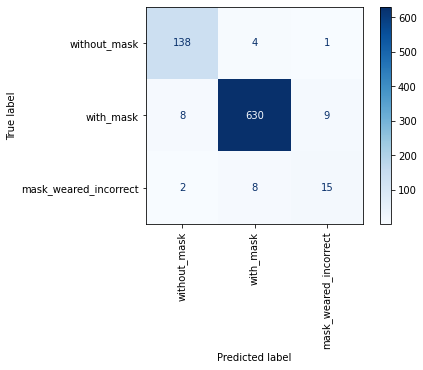

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=mask_labels, cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.savefig(proj_path + "/images/vgg_cm.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
cr = classification_report(y_true, y_pred, target_names=mask_labels)
print(cr)

                       precision    recall  f1-score   support

         without_mask       0.93      0.97      0.95       143
            with_mask       0.98      0.97      0.98       647
mask_weared_incorrect       0.60      0.60      0.60        25

             accuracy                           0.96       815
            macro avg       0.84      0.85      0.84       815
         weighted avg       0.96      0.96      0.96       815

